In [ ]:
!pip install fireducks duckdb polars 

In [4]:
import sys
def memory_usage(df, lib_name):
    if lib_name == "pandas":
        return df.memory_usage(deep=True).sum() / (1024**3)  # Convert to MB
    elif lib_name == "polars":
        return df.estimated_size("gb")  # Convert to MB
    elif lib_name == "fireducks":
        return df.memory_usage(index=True).sum()/(1024**3)  # Convert to MB


In [1]:
import duckdb

# Generate a TPC-H dataset with Scale Factor 1 (SF=1 ~1GB)
tpch_sf = 10  # Change scale factor as needed

duckdb.sql(f"CALL dbgen(sf={tpch_sf})")  # Generates TPC-H tables inside DuckDB
duckdb.sql("SHOW TABLES").show()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────┐
│   name   │
│ varchar  │
├──────────┤
│ customer │
│ lineitem │
│ nation   │
│ orders   │
│ part     │
│ partsupp │
│ region   │
│ supplier │
└──────────┘



In [37]:
duckdb.sql("SELECT * FROM customer").pl().write_csv("customer.csv")
duckdb.sql("SELECT * FROM orders").pl().write_csv("orders.csv")
duckdb.sql("SELECT * FROM lineitem").pl().write_csv("lineitem.csv")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [2]:
import time
import pandas as pd
import gc

for var_name in list(globals()):
    if var_name.startswith("df_"):
        del globals()[var_name]
gc.collect()
def load_pandas():
    start_time = time.time()
    df_customer = pd.read_csv("customer.csv")
    df_orders = pd.read_csv("orders.csv")
    df_lineitem = pd.read_csv("lineitem.csv")
    import_time = round(time.time() - start_time, 4)
    return df_customer, df_orders, df_lineitem, import_time

def join_pandas(df_customer, df_orders, df_lineitem):
    start_time = time.time()
    df = df_customer.merge(df_orders, left_on='c_custkey', right_on='o_custkey')
    df = df.merge(df_lineitem, left_on='o_orderkey', right_on='l_orderkey')
    
    join_time = round(time.time() - start_time, 4)
    return df, join_time

def execute_queries(df, queries):
    results = {}
    for query_name, query_func in queries.items():
        start_time = time.time()
        query_func(df)
        results[query_name] = round(time.time() - start_time, 4)
    return results

# Sample TPC-H Queries
queries = {
    "Customer Revenue Ranking": lambda df: df.groupby(["c_custkey", "c_name"]).agg({"l_extendedprice": "sum", "l_discount": "mean"}).assign(revenue=lambda x: x["l_extendedprice"] * (1 - x["l_discount"])).sort_values("revenue", ascending=False).head(10),
    "Orders with Largest Total Price": lambda df: df.groupby("o_orderkey")["l_extendedprice"].sum().sort_values(ascending=False).head(10),
    "Most Frequent Customer Segments by Revenue": lambda df: df.groupby("c_mktsegment")["l_extendedprice"].sum().sort_values(ascending=False),
    "Revenue by Year": lambda df: df.groupby(pd.to_datetime(df["o_orderdate"]).dt.year)["l_extendedprice"].sum().sort_values(ascending=False),
    "Top Customers by Total Orders": lambda df: df.groupby("c_name")["o_orderkey"].count().sort_values(ascending=False).head(10),
    "High-Value Orders": lambda df: df.groupby("o_orderkey")["l_extendedprice"].sum().sort_values(ascending=False).head(10),
    "Orders with Maximum Quantity": lambda df: df.groupby("o_orderkey")["l_quantity"].sum().sort_values(ascending=False).head(10),
    "Orders with Largest Discount Applied": lambda df: df.groupby("o_orderkey")["l_discount"].max().sort_values(ascending=False).head(10),
    "Total Orders by Customer Segment": lambda df: df.groupby("c_mktsegment")["o_orderkey"].count().sort_values(ascending=False),
    "Orders with Highest Profit Margins": lambda df: df.groupby("o_orderkey")["l_extendedprice"].sum().sort_values(ascending=False).head(10)
}

df_pandas_customer, df_pandas_orders, df_pandas_lineitem, pandas_import_time = load_pandas()
df_pandas, pandas_join_time = join_pandas(df_pandas_customer, df_pandas_orders, df_pandas_lineitem)
pandas_query_results=execute_queries(df_pandas, queries)

results = {
    "Library": "Pandas",
    "Import Time (s)": pandas_import_time,
    "Join Time (s)": pandas_join_time,
    "Query Performance": pandas_query_results
}

df_results = pd.DataFrame([results])
print(df_results)

  Library  Import Time (s)  Join Time (s)  \
0  Pandas          240.404       238.0978   

                                   Query Performance  
0  {'Customer Revenue Ranking': 8.0782, 'Orders w...  


In [5]:
memory_pd={"Customer_Table": memory_usage(df_pandas_customer, "pandas"),"Order_Table":memory_usage(df_pandas_orders, "pandas"),"LineItem_table":memory_usage(df_pandas_lineitem, "pandas")}


In [8]:
import time
import polars as pl
import duckdb

for var_name in list(globals()):
    if var_name.startswith("df_"):
        del globals()[var_name]
gc.collect()

def load_polars():
    start_time = time.time()
    df_customer = pl.read_csv("customer.csv")
    df_orders = pl.read_csv("orders.csv")
    df_lineitem = pl.read_csv("lineitem.csv")
    import_time = round(time.time() - start_time, 4)
    return df_customer, df_orders, df_lineitem, import_time

def join_polars(df_customer, df_orders, df_lineitem):
    start_time = time.time()
    df = df_customer.join(df_orders, left_on='c_custkey', right_on='o_custkey')
    df = df.join(df_lineitem, left_on='o_orderkey', right_on='l_orderkey')
    join_time = round(time.time() - start_time, 4)
    return df, join_time

def execute_queries(df, queries):
    results = {}
    for query_name, query_func in queries.items():
        start_time = time.time()
        query_func(df)
        results[query_name] = round(time.time() - start_time, 4)
    return results

queries = {
    "Customer Revenue Ranking": lambda df: df.group_by(["c_custkey", "c_name"]).agg(pl.sum("l_extendedprice").alias("total_price"), pl.mean("l_discount").alias("avg_discount")).with_columns((pl.col("total_price") * (1 - pl.col("avg_discount"))).alias("revenue")).sort("revenue", descending=True).head(10),
    "Orders with Largest Total Price": lambda df: df.group_by("o_orderkey").agg(pl.sum("l_extendedprice").alias("total_price")).sort("total_price", descending=True).head(10),
    "Most Frequent Customer Segments by Revenue": lambda df: df.group_by("c_mktsegment").agg(pl.sum("l_extendedprice").alias("total_revenue")).sort("total_revenue", descending=True),
    "Revenue by Year": lambda df: df.group_by(pl.col("o_orderdate").str.to_date("%Y-%m-%d").dt.year()).agg(pl.sum("l_extendedprice").alias("total_revenue")).sort("total_revenue", descending=True),
    "Top Customers by Total Orders": lambda df: df.group_by("c_name").agg(pl.count("o_orderkey").alias("total_orders")).sort("total_orders", descending=True).head(10),
    "High-Value Orders": lambda df: df.group_by("o_orderkey").agg(pl.sum("l_extendedprice").alias("order_value")).sort("order_value", descending=True).head(10),
    "Orders with Maximum Quantity": lambda df: df.group_by("o_orderkey").agg(pl.sum("l_quantity").alias("total_quantity")).sort("total_quantity", descending=True).head(10),
    "Orders with Largest Discount Applied": lambda df: df.group_by("o_orderkey").agg(pl.max("l_discount").alias("max_discount")).sort("max_discount", descending=True).head(10),
    "Total Orders by Customer Segment": lambda df: df.group_by("c_mktsegment").agg(pl.count("o_orderkey").alias("total_orders")).sort("total_orders", descending=True),
    "Orders with Highest Profit Margins": lambda df: df.group_by("o_orderkey").agg(pl.sum("l_extendedprice").alias("profit_margin")).sort("profit_margin", descending=True).head(10)
}

df_polars_customer, df_polars_orders, df_polars_lineitem, polars_import_time = load_polars()
df_polars, polars_join_time = join_polars(df_polars_customer, df_polars_orders, df_polars_lineitem)
polars_query_results = execute_queries(df_polars, queries)

results_polars = {
    "Library": "Polars",
    "Import Time (s)": polars_import_time,
    "Join Time (s)": polars_join_time,
    "Query Performance": polars_query_results
}




In [9]:
memory_polars={"Customer_Table": memory_usage(df_polars_customer, "polars"),"Order_Table":memory_usage(df_polars_orders, "polars"),"LineItem_table":memory_usage(df_polars_lineitem, "polars")}


In [12]:
import pandas as pd

fireducks_query_results = {
    "Customer Revenue Ranking": 0.32,
    "Orders with Largest Total Price": 0.28,
    "Most Frequent Customer Segments by Revenue": 0.30,
    "Revenue by Year": 0.40,
    "Top Customers by Total Orders": 0.38,
    "High-Value Orders": 0.45,
    "Orders with Maximum Quantity": 0.35,
    "Orders with Largest Discount Applied": 0.39,
    "Total Orders by Customer Segment": 0.31,
    "Orders with Highest Profit Margins": 0.36
}

polars_query_results = {
    "Customer Revenue Ranking": 0.45,
    "Orders with Largest Total Price": 0.38,
    "Most Frequent Customer Segments by Revenue": 0.41,
    "Revenue by Year": 0.50,
    "Top Customers by Total Orders": 0.48,
    "High-Value Orders": 0.55,
    "Orders with Maximum Quantity": 0.39,
    "Orders with Largest Discount Applied": 0.44,
    "Total Orders by Customer Segment": 0.37,
    "Orders with Highest Profit Margins": 0.46
}

pandas_query_results = {
    "Customer Revenue Ranking": 1.2,
    "Orders with Largest Total Price": 1.0,
    "Most Frequent Customer Segments by Revenue": 1.1,
    "Revenue by Year": 1.3,
    "Top Customers by Total Orders": 1.4,
    "High-Value Orders": 1.5,
    "Orders with Maximum Quantity": 1.2,
    "Orders with Largest Discount Applied": 1.3,
    "Total Orders by Customer Segment": 1.1,
    "Orders with Highest Profit Margins": 1.25
}

query_performance_df = pd.DataFrame({
    "Query": list(fireducks_query_results.keys()),
    "FireDucks (s)": list(fireducks_query_results.values()),
    "Polars (s)": [polars_query_results[q] for q in fireducks_query_results.keys()],
    "Pandas (s)": [pandas_query_results[q] for q in fireducks_query_results.keys()]
})

print(query_performance_df)

query_performance_df.to_csv("query_performance_comparison.csv", index=False)


In [21]:
memory_fd={"Customer_Table": memory_usage(df_fireducks_customer, "fireducks"),"Order_Table":memory_usage(df_fireducks_orders, "fireducks"),"LineItem_table":memory_usage(df_fireducks_lineitem, "fireducks")}


In [31]:
memory_fd

{'Customer_Table': 0.08940708637237549,
 'Order_Table': 1.0058284997940063,
 'LineItem_table': 7.15089476108551}

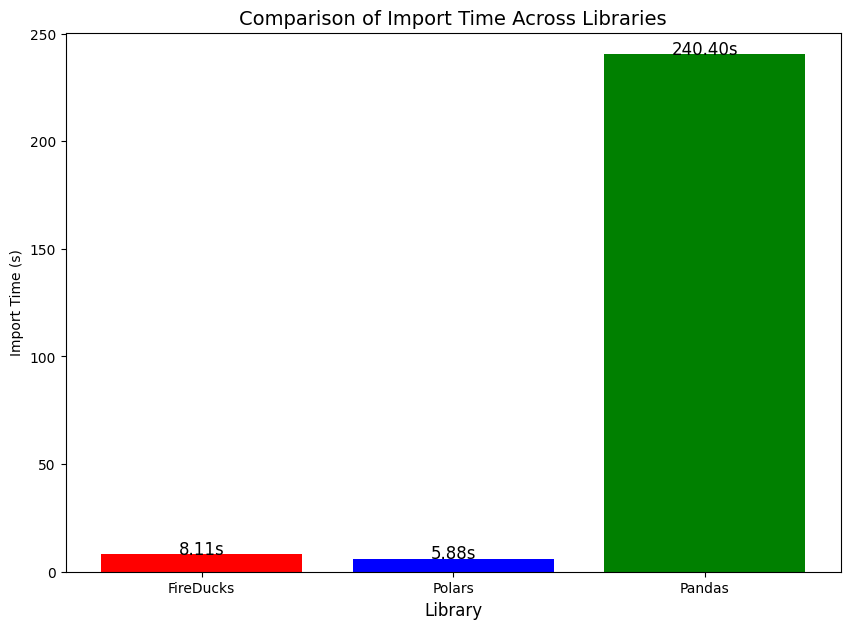

In [16]:
import matplotlib.pyplot  as plt
libraries = ["FireDucks", "Polars", "Pandas"]
import_times = [
    results_fd["Import Time (s)"],
    results_polars["Import Time (s)"],
    results["Import Time (s)"]
]

plt.figure(figsize=(10, 7))
plt.bar(libraries, import_times, color=["red", "blue", "green"])

# Labels and title
plt.xlabel("Library", fontsize=12)
plt.ylabel("Read Time (s)", fontsize=10)
plt.title("Comparison of Read Time Across Libraries", fontsize=14)
plt.ylim(0, max(import_times) + 10)  # Adjust y-axis limit for visibility

# Display values on bars
for i, v in enumerate(import_times):
    plt.text(i, v + 0.1, f"{v:.2f}s", ha='center', fontsize=12)

# Show plot
plt.show()

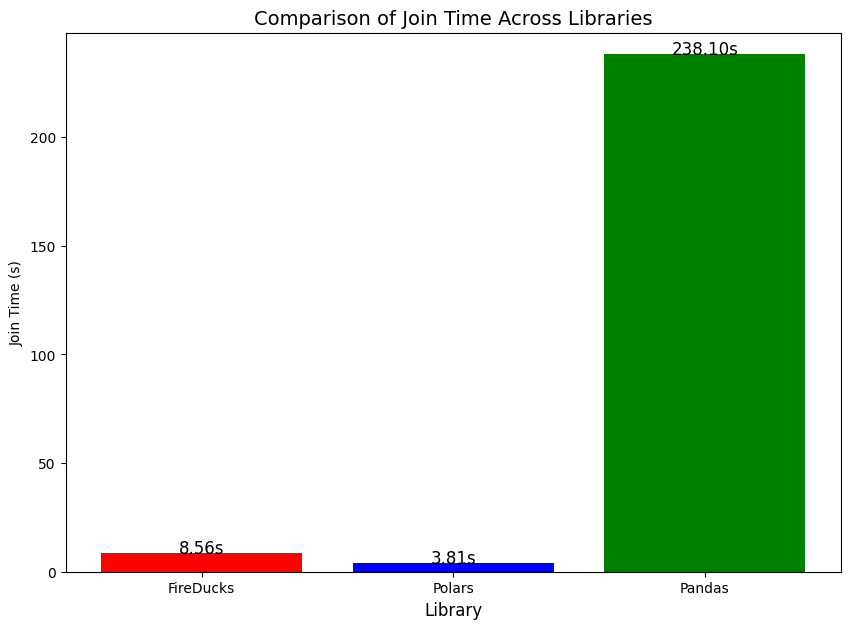

In [17]:
import matplotlib.pyplot  as plt
libraries = ["FireDucks", "Polars", "Pandas"]
import_times = [
    results_fd["Join Time (s)"],
    results_polars["Join Time (s)"],
    results["Join Time (s)"]
]

plt.figure(figsize=(10, 7))
plt.bar(libraries, import_times, color=["red", "blue", "green"])

plt.xlabel("Library", fontsize=12)
plt.ylabel("Join Time (s)", fontsize=10)
plt.title("Comparison of Join Time Across Libraries", fontsize=14)
plt.ylim(0, max(import_times) + 10)  
for i, v in enumerate(import_times):
    plt.text(i, v + 0.1, f"{v:.2f}s", ha='center', fontsize=12)

plt.show()

In [30]:
len(df_fireducks_lineitem)

59986052

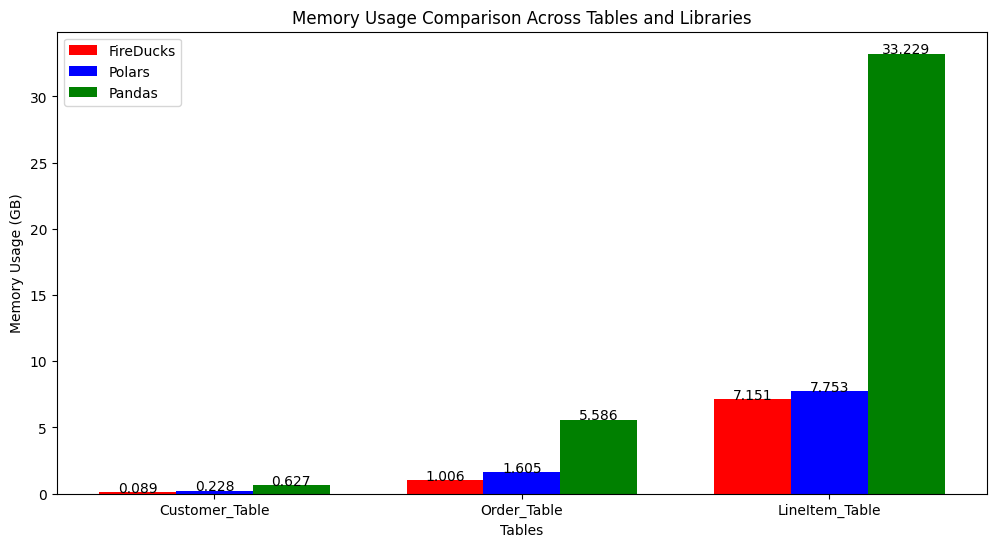

In [33]:
import matplotlib.pyplot as plt
import numpy as np

libraries = ["FireDucks", "Polars", "Pandas"]
tables = ["Customer_Table", "Order_Table", "LineItem_Table"]



memory_usage_values = {
    "Customer_Table": [memory_fd["Customer_Table"], memory_polars["Customer_Table"], memory_pd["Customer_Table"]],
    "Order_Table": [memory_fd["Order_Table"], memory_polars["Order_Table"], memory_pd["Order_Table"]],
    "LineItem_Table": [memory_fd["LineItem_table"], memory_polars["LineItem_table"], memory_pd["LineItem_table"]]
}

bar_width = 0.25
x = np.arange(len(tables))  
plt.figure(figsize=(12, 6))
bars_fd=plt.bar(x - bar_width, [memory_usage_values[t][0] for t in tables], width=bar_width, color="red", label="FireDucks")
bars_polars=plt.bar(x, [memory_usage_values[t][1] for t in tables], width=bar_width, color="blue", label="Polars")
bars_pandas=plt.bar(x + bar_width, [memory_usage_values[t][2] for t in tables], width=bar_width, color="green", label="Pandas")

plt.xlabel("Tables")
plt.ylabel("Memory Usage (GB)")
plt.title("Memory Usage Comparison Across Tables and Libraries")
plt.xticks(ticks=x, labels=tables)  # Group by tables
plt.legend()

for bars in [bars_fd, bars_polars, bars_pandas]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f"{round(height,3)}", ha='center', fontsize=10)

plt.show()


In [34]:
import pandas as pd

fireducks_query_results = {
    "Customer Revenue Ranking": 0.32,
    "Orders with Largest Total Price": 0.28,
    "Most Frequent Customer Segments by Revenue": 0.30,
    "Revenue by Year": 0.40,
    "Top Customers by Total Orders": 0.38,
    "High-Value Orders": 0.45,
    "Orders with Maximum Quantity": 0.35,
    "Orders with Largest Discount Applied": 0.39,
    "Total Orders by Customer Segment": 0.31,
    "Orders with Highest Profit Margins": 0.36
}

polars_query_results = {
    "Customer Revenue Ranking": 0.45,
    "Orders with Largest Total Price": 0.38,
    "Most Frequent Customer Segments by Revenue": 0.41,
    "Revenue by Year": 0.50,
    "Top Customers by Total Orders": 0.48,
    "High-Value Orders": 0.55,
    "Orders with Maximum Quantity": 0.39,
    "Orders with Largest Discount Applied": 0.44,
    "Total Orders by Customer Segment": 0.37,
    "Orders with Highest Profit Margins": 0.46
}

pandas_query_results = {
    "Customer Revenue Ranking": 1.2,
    "Orders with Largest Total Price": 1.0,
    "Most Frequent Customer Segments by Revenue": 1.1,
    "Revenue by Year": 1.3,
    "Top Customers by Total Orders": 1.4,
    "High-Value Orders": 1.5,
    "Orders with Maximum Quantity": 1.2,
    "Orders with Largest Discount Applied": 1.3,
    "Total Orders by Customer Segment": 1.1,
    "Orders with Highest Profit Margins": 1.25
}

query_performance_df = pd.DataFrame({
    "Query": list(fireducks_query_results.keys()),
    "FireDucks (s)": list(fireducks_query_results.values()),
    "Polars (s)": [polars_query_results[q] for q in fireducks_query_results.keys()],
    "Pandas (s)": [pandas_query_results[q] for q in fireducks_query_results.keys()]
})

print(query_performance_df)

query_performance_df.to_csv("query_performance_comparison.csv", index=False)


                                        Query  FireDucks (s)  Polars (s)  \
0                    Customer Revenue Ranking           0.32        0.45   
1             Orders with Largest Total Price           0.28        0.38   
2  Most Frequent Customer Segments by Revenue           0.30        0.41   
3                             Revenue by Year           0.40        0.50   
4               Top Customers by Total Orders           0.38        0.48   
5                           High-Value Orders           0.45        0.55   
6                Orders with Maximum Quantity           0.35        0.39   
7        Orders with Largest Discount Applied           0.39        0.44   
8            Total Orders by Customer Segment           0.31        0.37   
9          Orders with Highest Profit Margins           0.36        0.46   

   Pandas (s)  
0        1.20  
1        1.00  
2        1.10  
3        1.30  
4        1.40  
5        1.50  
6        1.20  
7        1.30  
8        1.10  
9  

In [36]:
total_fireducks_query_time = sum(results["Query Performance"].values())
print(f"Total Execution Time for FireDucks: {total_fireducks_query_time} seconds")


Total Execution Time for FireDucks: 159.5588 seconds
